Підготувати середовище для виконання лабораторної роботи (локальне чи Colab)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Завантажити дані для навчання (CIFAR10, див. методичні матеріали для готового фрагменту коду);

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


Навчити повнозв’язну нейронну мережу із запропонованою архітектурою (приклад з методичних матеріалів) та налаштуваннями компіляції:

Навчити мережу не змінюючи гіперпараметрів, заданих у прикладі;

In [ ]:
id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}


Повнозв’язна мережа з Functional API

In [ ]:
def construct_model(input_shape: tuple[int,...], dim_per_layer: list[int], n_classes: int) -> tf.keras.Model:
    input_x = tf.keras.layers.Input(shape=input_shape)


    x = tf.keras.layers.Flatten()(input_x)
    for dim in dim_per_layer:
        x = tf.keras.layers.Dense(dim, activation='relu')(x)

    out_x = tf.keras.layers.Dense(n_classes)(x) # можна додати activation = 'softmax'


    return tf.keras.Model(inputs=input_x, outputs=out_x)


model = construct_model((32,32,3), dim_per_layer=[100, 100], n_classes=len(id2class))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # спарс версія оскільки y_train та y_test містять номери класів
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
hist = model.fit(
    x=x_train,
    y=y_train,
    # кількість епох
    epochs=100,
    # розмір партії даних
    batch_size=128,
    validation_data=(x_test, y_test)
)


Epoch 1/100
391/391 [==============================] - 3s 4ms/step - loss: 146.1159 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
391/391 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
391/391 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
391/391 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
391/391 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
391/391 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
391/391 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.0957 - val_loss: 2.3026 - val_accuracy: 0.10

Оцінити метрики моделі на тестовій вибірці;

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 2.3026 - accuracy: 0.1000 - 532ms/epoch - 2ms/step


Побудувати криві навчання для моделі (для функції втрат та метрики точності);

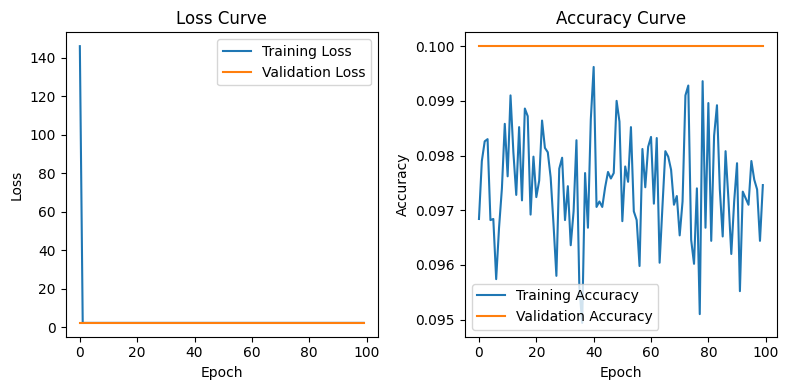

In [ ]:
# Візуалізація історії навчання
def plot_history(history):
    plt.figure(figsize=(8,4))

    # Побудова кривої втрат
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Побудова кривої точності
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Виклик функції для побудови графіків
plot_history(hist)

Побудувати classification_report та confusion_matrix для результатів моделі на тестовій виборці, зробити висновки;

In [ ]:
# обчислення передбачуваних значень y
predictions = model.predict(x_test)
# перетворення векторів прогнозів на мітки класів
y_pred = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
# матриця помилок
confusion_matrix(y_test, y_pred)

array([[   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0]])

In [ ]:
# звіт класифікації
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.10      1.00      0.18      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 318410 (1.21 MB)
Trainable params: 318410 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Порівняти розміри моделей та час їх навчання;
1. Початкова модель - 203.814 s, 1.21 MB